In [1]:
import cv2
import numpy as np
from tqdm import tqdm
import pandas as pd

In [2]:
df = pd.read_csv('../dog/labels.csv')
#df_test = pd.read_csv('../dog/sample_submission.csv')
df.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [3]:
df.shape

(10222, 2)

In [4]:
n = len(df)
breed = set(df['breed'])
n_class = len(breed)
class_to_num = dict(zip(breed, range(n_class)))
num_to_class = dict(zip(range(n_class), breed))

In [11]:
width = 299
X = np.zeros((n, width, width, 3), dtype = np.uint8)
y = np.zeros((n, n_class), dtype = np.uint8)
for i in tqdm(range(n)):
    X[i] = cv2.resize(cv2.imread('train/%s.jpg'%df['id'][i]), (width, width))
    y[i][class_to_num[df['breed'][i]]] = 1

100%|██████████| 10222/10222 [00:58<00:00, 174.26it/s]


In [13]:
import random
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

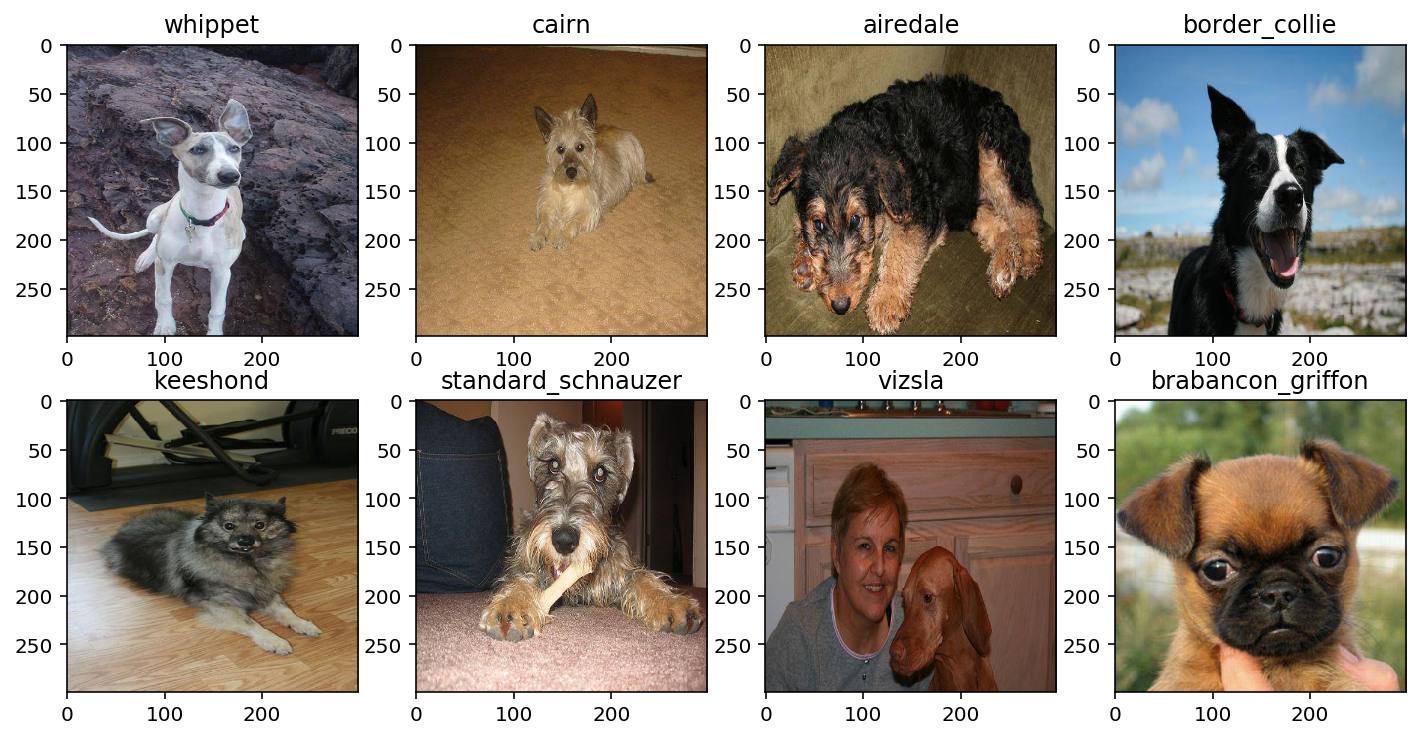

In [17]:
plt.figure(figsize = (12, 6))
for i in range(8):
    random_index = random.randint(0, n-1)
    plt.subplot(2, 4, i+1)
    plt.imshow(X[random_index][:,:,::-1])
    plt.title(num_to_class[y[random_index].argmax()])

In [18]:
from keras.layers import *
from keras.models import *
from keras.applications import *
from keras.optimizers import *
from keras.regularizers import *
from keras.applications.inception_v3 import preprocess_input

/Users/suzukishinji/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/suzukishinji/anaconda/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [19]:
def get_features(MODEL, data = X):
    cnn_model = MODEL(include_top = False, input_shape = (width, width, 3), weights = 'imagenet')
    inputs = Input((width, width, 3))
    x = inputs
    x = Lambda(preprocess_input, name = 'preprocessing')(x)
    x = cnn_model(x)
    x = GlobalAveragePooling2D()(x)
    cnn_model = Model(inputs, x)
    features = cnn_model.predict(data, batch_size = 64, verbose = 1)
    return features

In [20]:
inception_features = get_features(InceptionV3, X)
xception_features = get_features(Xception, X)
features = np.concatenate([inception_features, xception_features], axis = 1)

10222/10222 [==============================] - 69131s 7s/step


In [22]:
inputs = Input(features.shape[1:])
x = inputs
x = Dropout(0.5)(x)
x = Dense(n_class, activation = 'softmax')(x)
model = Model(inputs, x)
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
h = model.fit(features, y, batch_size = 128, epochs = 10, validation_split = 0.1)

Train on 9199 samples, validate on 1023 samples
Epoch 1/10
9199/9199 [==============================] - 6s 618us/step - loss: 1.8704 - acc: 0.5982 - val_loss: 0.7001 - val_acc: 0.8084
Epoch 2/10
9199/9199 [==============================] - 3s 285us/step - loss: 0.5810 - acc: 0.8419 - val_loss: 0.5408 - val_acc: 0.8436
Epoch 3/10
9199/9199 [==============================] - 2s 267us/step - loss: 0.4418 - acc: 0.8714 - val_loss: 0.5205 - val_acc: 0.8319
Epoch 4/10
9199/9199 [==============================] - 2s 240us/step - loss: 0.3568 - acc: 0.8971 - val_loss: 0.4759 - val_acc: 0.8485
Epoch 5/10
9199/9199 [==============================] - 2s 245us/step - loss: 0.3024 - acc: 0.9126 - val_loss: 0.4722 - val_acc: 0.8485
Epoch 6/10
9199/9199 [==============================] - 2s 246us/step - loss: 0.2614 - acc: 0.9281 - val_loss: 0.4808 - val_acc: 0.8416
Epoch 7/10
9199/9199 [==============================] - 2s 249us/step - loss: 0.2352 - acc: 0.9336 - val_loss: 0.4576 - val_acc: 0.8563


In [23]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [24]:
SVG(model_to_dot(model, show_shapes = True).create(prog = 'dot', format = 'svg'))
SVG(model_to_dot(model, show_shapes = True).create(prog = 'dot', format = 'svg'))

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [26]:
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

AttributeError: 'History' object has no attribute 'shitory'

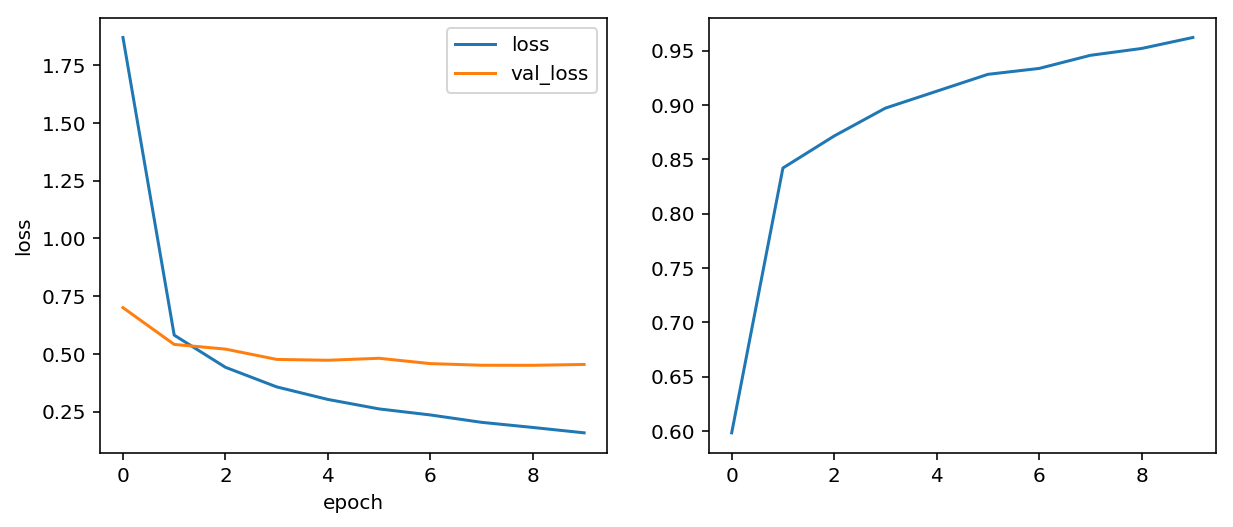

In [27]:
plt.figure(figsize = (10, 4))
plt.subplot(1,2,1)
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.legend((['loss', 'val_loss']))
plt.ylabel('loss')
plt.xlabel('epoch')

plt.subplot(1,2,2)
plt.plot(h.history['acc'])
plt.plot(h.shitory['val_acc'])
plt.legend((['acc', 'val_acc']))
plt.ylabel('acc')
plt.xlabel('epoch')

In [28]:
df2 = pd.read_csv('../dog/sample_submission.csv')

In [29]:
n_test = len(df2)
X_test = np.zeros((n_test, width, width, 3), dtype = np.uint8)
for i in tqdm(range(n_test)):
    X_test[i] = cv2.resize(cv2.imread('test/%s.jpg'%df2['id'][i]), (width, width))

100%|██████████| 10357/10357 [00:59<00:00, 175.40it/s]


In [30]:
inception_features = get_features(InceptionV3, X_test)
xception_features = get_features(Xception, X_test)
features_test = np.concatenate([inception_features, xception_features], axis = 1)

10357/10357 [==============================] - 13122s 1s/step


NameError: name 'inception__features' is not defined

In [31]:
features_test = np.concatenate([inception_features, xception_features], axis = 1)

In [32]:
y_pred = model.predict(features_test, batch_size = 128)

In [33]:
for b in breed:
    df2[b] = y_pred[:, class_to_num[b]]

In [34]:
df2.to_csv('pred_0201.csv', index = None)

In [35]:
submit_1 = pd.read_csv('/Users/suzukishinji/kaggle/dog/pred_0201.csv')
submit_1.head()

,id,affenpinscher,afghan_hound,african_hunting_dog,airedale,american_staffordshire_terrier,appenzeller,australian_terrier,basenji,basset,...,toy_poodle,toy_terrier,vizsla,walker_hound,weimaraner,welsh_springer_spaniel,west_highland_white_terrier,whippet,wire-haired_fox_terrier,yorkshire_terrier
0,000621fb3cbb32d8935728e48679680e,2.531553e-06,0.000002,6.056676e-07,1.390094e-06,1.920809e-07,9.743758e-07,7.760064e-07,3.610431e-07,4.221223e-07,...,8.009755e-07,8.455406e-07,0.000001,9.291633e-08,1.959011e-07,1.304231e-06,5.160982e-07,3.580224e-07,2.345691e-06,3.939155e-07
1,00102ee9d8eb90812350685311fe5890,2.943210e-06,0.000004,2.051896e-06,1.707371e-06,2.284030e-05,6.029520e-05,5.170236e-06,2.485200e-05,2.008560e-06,...,6.453114e-06,2.182358e-06,0.000004,4.346838e-06,7.533655e-06,5.228311e-07,1.429823e-04,1.780382e-06,2.559555e-06,3.454485e-06
2,0012a730dfa437f5f3613fb75efcd4ce,2.306698e-07,0.000706,1.056863e-05,1.488627e-05,9.737690e-08,2.316538e-06,5.345326e-07,1.516445e-06,1.467364e-05,...,3.177586e-07,5.563811e-07,0.000066,2.309718e-05,7.610557e-06,1.899882e-03,9.193790e-07,3.281263e-05,9.090519e-07,4.952201e-07
3,001510bc8570bbeee98c8d80c8a95ec1,3.888418e-04,0.000006,2.912363e-07,5.530924e-07,4.410512e-05,2.340087e-05,1.494005e-06,4.995092e-05,2.795273e-06,...,1.603089e-05,3.964527e-06,0.000002,7.460466e-07,5.964623e-07,1.411174e-07,1.603827e-06,1.285137e-05,3.191597e-07,8.948940e-07
4,001a5f3114548acdefa3d4da05474c2e,6.070173e-03,0.000057,5.549851e-06,3.381485e-07,7.609368e-06,2.280512e-05,4.071790e-04,4.269053e-05,3.005032e-05,...,6.593017e-05,1.727940e-04,0.000051,7.292875e-06,2.385680e-06,8.927427e-06,1.795853e-04,2.279538e-05,1.624022e-04,2.067147e-03
